# Image Subtraction Module

**Lecturer:** Christoffer Fremling<br>
**Jupyter Notebook Authors:** Igor Andreoni, Christoffer Fremling and Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2019.html

## Objective
Learn how to perform image subtraction to discover astronomical transients from multiple consecutive images.

## Key steps
- Register science and reference images (make them aligned and of the same size)
- PSF extraction, using PSFex
- PSF matching by convolution
- [Zero-point calibration]
- Image subtraction

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* pytest
* photutils

### External packages
* SWarp https://www.astromatic.net/software
* SExtractor https://www.astromatic.net/software
* PSFex https://www.astromatic.net/software
* ds9 http://ds9.si.edu/site/Home.html 

In [ ]:
# Import the relevant packages

import numpy as np
from astropy.io import fits #FITS files handling
import os  #Call commands from outside Python
from astropy.io import ascii  #Read/write ascii files

# Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve 
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats

from astropy.coordinates import SkyCoord
from astropy import units as u

# Background subtraction
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
from photutils import make_source_mask

# Plot
import matplotlib.pyplot as plt

# Running external programs
import subprocess
import shutil

## Test dependencies

In order for this jupyter notebook to function correctly, we must have some external software installed, as described above.  The following step assures that these are installed properly before getting to the rest of the content of this lesson.

In [ ]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

## Set up paths and clear old temp files

In [3]:
# remove temporary fits files in current working directory
[os.remove(f) for f in os.listdir() if f.endswith('.fits')]

# Set directory structure
cwd = os.getcwd()
proc_dir = os.path.join(cwd, 'processed')
data_dir = os.path.join(cwd, 'data')
out_dir = os.path.join(proc_dir, 'out')
if os.path.isdir(proc_dir): 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)

for f in os.listdir(data_dir):
    shutil.copy2(os.path.join(data_dir, f), os.path.join(proc_dir, f))
os.chdir(proc_dir)

## Reference and science images

Define the reference and science images. Open them with ds9 to give them a look. <br />
Also, what is the size of the images in pixel?  This information will be useful when we want to align the images using Swarp.

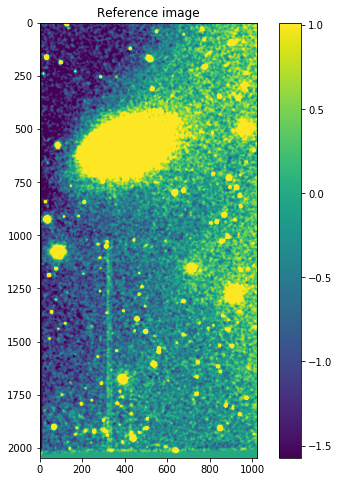

The dimension of the X axis of the reference image is 
1024
The dimension of the Y axis of the reference image is 
2048


In [4]:
# Reference image
ref_image_name = os.path.join(data_dir, 'refimg_i.fits')
ref_image = fits.open(ref_image_name)

#Plot up the reference image
mean, median, std = sigma_clipped_stats(ref_image[0].data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(ref_image[0].data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.title('Reference image')
plt.show()

#Image size?
print("The dimension of the X axis of the reference image is ")
print(ref_image[0].header["NAXIS1"])
print("The dimension of the Y axis of the reference image is ")
print(ref_image[0].header["NAXIS2"])

Let's do the same for the science image.  Can you already spot the Supernova? 

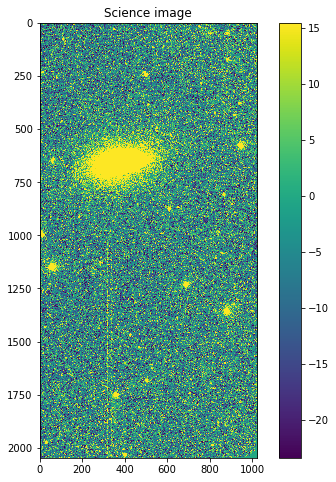

The dimension of the X axis of the science image is 
1024
The dimension of the Y axis of the science image is 
2048


In [5]:
#Science image
sci_image_name=os.path.join(data_dir, '20120419094409p.fits')
sci_image = fits.open(sci_image_name)

#Open the images 
##os.system('ds9 -zscale '+sci_image_name +' ' + ref_image_name +'&')

#Plot up the science image
mean, median, std = sigma_clipped_stats(sci_image[0].data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(sci_image[0].data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.title('Science image')
plt.show()

#Image size?
print("The dimension of the X axis of the science image is ")
print(sci_image[0].header["NAXIS1"])
print("The dimension of the Y axis of the science image is ")
print(sci_image[0].header["NAXIS2"])

## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated.

In [6]:
#Swarp command
try:
    command = "SWarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(data_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

#Names of the aligned images
sci_image_aligned_name=sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
ref_image_aligned_name=ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')

Executing command: SWarp /home/growth/Downloads/working_copies/image_subtraction/data/20120419094409p.fits /home/growth/Downloads/working_copies/image_subtraction/data/refimg_i.fits -c /home/growth/Downloads/working_copies/image_subtraction/data/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900
Success!


If we attempt an image subtraction now, what does the result look like?

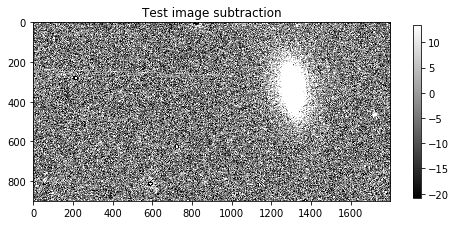

In [7]:
#Test image subtraction:
ref_image_aligned=fits.open(ref_image_aligned_name)
hdr_ref=ref_image_aligned[0].header #save fits header
sci_image_aligned=fits.open(sci_image_aligned_name)
hdr_sci=sci_image_aligned[0].header #save fits header
image_sub = sci_image_aligned[0].data-ref_image_aligned[0].data
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test_0.fits", overwrite = True)

#Plot up the result of the image subtraction
mean, median, std = sigma_clipped_stats(hdu_image_sub.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_image_sub.data, vmin = median - 2*std, vmax = median + 2*std, cmap='gray')
plt.colorbar(shrink = 0.4)
plt.title('Test image subtraction')
plt.show()

# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping, 15 iterations to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

In [8]:
# Background subtraction.  Import the relevant packages
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
from photutils import make_source_mask
mask_sci = make_source_mask(sci_image_aligned[0].data, snr=2, npixels=3, dilate_size=11)
mask_ref = make_source_mask(ref_image_aligned[0].data, snr=2, npixels=3, dilate_size=11)

sci_image_aligned_name=os.path.join(proc_dir, "bg_sub_sci.fits")
ref_image_aligned_name=os.path.join(proc_dir, "bg_sub_ref.fits")

# remove temporary fits files
if os.path.exists(sci_image_aligned_name): os.remove(sci_image_aligned_name)
if os.path.exists(ref_image_aligned_name): os.remove(ref_image_aligned_name)

sigma_clip = SigmaClip(sigma=3, iters=15) # Sigma clipping
bkg_estimator = MedianBackground()
bkg_sci = Background2D(sci_image_aligned[0].data, (200, 150), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask=mask_sci)
bkg_ref = Background2D(ref_image_aligned[0].data, (200, 150), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask=mask_ref)

#Remove the background from the science image
sci_image_aligned[0].data = sci_image_aligned[0].data-bkg_sci.background
hdu_image_sub=fits.PrimaryHDU(sci_image_aligned[0].data-bkg_sci.background)
hdu_image_sub.writeto(sci_image_aligned_name)

#Remove the background from the reference image
ref_image_aligned[0].data = ref_image_aligned[0].data-bkg_ref.background
hdu_image_sub=fits.PrimaryHDU(ref_image_aligned[0].data-bkg_ref.background)
hdu_image_sub.writeto(ref_image_aligned_name)

What do the background-subtracted images look like?

Executing command: ds9 -zscale /home/growth/Downloads/working_copies/image_subtraction/processed/bg_sub_sci.fits /home/growth/Downloads/working_copies/image_subtraction/processed/bg_sub_ref.fits
Success!


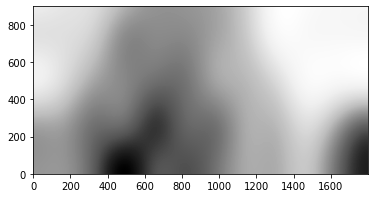

In [9]:
#Display with ds9
try:
    command = "ds9 -zscale %s %s" % (sci_image_aligned_name, ref_image_aligned_name)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run ds9 with exit error %s'%err)

#Plot here the background image
plt.imshow(bkg_sci.background, origin='lower', cmap='Greys_r')
#plt.imshow(sci_image_aligned[0].data-bkg_sci.background, origin='lower', cmap='Greys_r')

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on both the science image.  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  

In [10]:
if os.path.exists('prepsfex.cat'): #Remove possible temporary files
    os.remove("prepsfex.cat") 
try:
    command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(data_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: sextractor /home/growth/Downloads/working_copies/image_subtraction/processed/bg_sub_sci.fits -c /home/growth/Downloads/working_copies/image_subtraction/data/prepsfex.sex -CATALOG_NAME /home/growth/Downloads/working_copies/image_subtraction/data/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to measure the PSF of the science image. PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

/home/growth/Downloads/working_copies/image_subtraction/processed/out/proto_prepsfex.fits


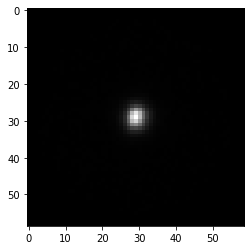

In [11]:
#Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')
shutil.copy2(os.path.join(data_dir, 'prepsfex.cat'), os.path.join(proc_dir, 'prepsfex.cat'))

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_sci_image_name=os.path.join(out_dir,'proto_prepsfex.fits')
print(psf_sci_image_name)
psf_sci_image = fits.open(psf_sci_image_name)

plt.imshow(psf_sci_image[0].data[0], cmap='gray')


### Convolve the reference image with the PSF of the science image
Now that the kernel is generated, let's convolve the reference image with the PSF of the science frame.  

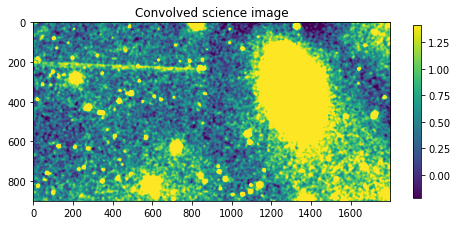

In [12]:
#Convolve the reference image with the PSF of the science frame
if os.path.exists(os.path.join(proc_dir, 'ref_convolved.fits')): 
    os.remove(os.path.join(proc_dir, 'ref_convolved.fits'))

kernel_sci = psf_sci_image[0].data[0]
ref_image_aligned=fits.open(ref_image_aligned_name)
ref_conv = scipy_convolve(ref_image_aligned[0].data, kernel_sci, mode='same', method='fft')

#Create a new fits file for the convolved image
hdu_ref_conv = fits.PrimaryHDU(ref_conv,hdr_ref)
hdu_ref_conv.writeto(os.path.join(proc_dir, "ref_convolved.fits"))

#Plot up the convolved reference image
mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_ref_conv.data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved reference image')
plt.show()


### Convolve the science image with the PSF of the reference image

Same as above, but this time we generate a kernel with the properties of the PSF of the reference image.  Then, we convolve the science image with this kernel.

In [13]:
#SExtractor command for the ref image
if os.path.exists('prepsfex.cat'): 
    os.remove("prepsfex.cat")

try:
    command = command="sextractor %s -c prepsfex.sex -CATALOG_NAME prepsfex.cat -MAG_ZEROPOINT 25.0" % ref_image_aligned_name
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: sextractor /home/growth/Downloads/working_copies/image_subtraction/processed/bg_sub_ref.fits -c prepsfex.sex -CATALOG_NAME prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Executing command: psfex prepsfex.cat -c psfex_conf.psfex

Success!


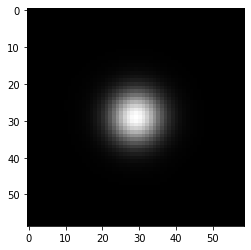

In [14]:
#Run PSFex to compute PSF, read and display the final model 
if os.path.exists(os.path.join(out_dir,'proto_prepsfex.fits')): 
    os.remove(os.path.join(out_dir, 'proto_prepsfex.fits'))

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_ref_image_name = os.path.join(out_dir, 'proto_prepsfex.fits')
psf_ref_image = fits.open(psf_ref_image_name)

plt.imshow(psf_ref_image[0].data[0], cmap='gray')


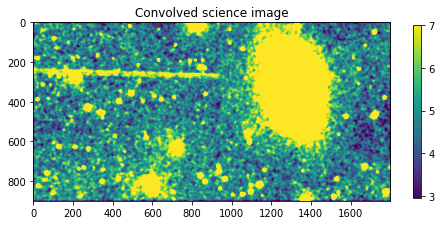

In [15]:
kernel_ref = psf_ref_image[0].data[0]

# Read the SCIENCE image and convolve it with the PSF of the reference frame
sci_image_aligned=fits.open(sci_image_aligned_name)
sci_conv = scipy_convolve(sci_image_aligned[0].data, kernel_ref, mode='same', method='fft')

#Create a new fits file for the convolved image
hdu_sci_conv = fits.PrimaryHDU(sci_conv,hdr_sci)
hdu_sci_conv.writeto("sci_convolved.fits")

#Plot up the convolved science image
mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_sci_conv.data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved science image')
plt.show()


### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image

In [16]:
#Test image subtraction:
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import numpy.fft

# Fine tuning of image alignment
xoff, yoff, exoff, eyoff = chi2_shift(ref_conv, sci_conv, 10, return_error=True, upsample_factor='auto')
print(xoff,yoff)

sci_conv_shift=scipy.ndimage.shift(sci_conv, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)



/home/growth/miniconda3/lib/python3.7/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/growth/miniconda3/lib/python3.7/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/home/growth/miniconda3/lib/python3.7/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; u

0.572265625 0.076171875


## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

In [17]:
# Normalize images using the stars in the image

#Run SExtractor on the science image
sextractor_command = "sextractor sci_convolved.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"

try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

cat_sci = ascii.read('sci_match.cat')


#Run SExtractor on the reference image
sextractor_command = "sextractor ref_convolved.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"

try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)
cat_ref=ascii.read('ref_match.cat')


Match the catalog of sources of the reference and science images.  Calculate the ratio between the flux of source in the science image over the flux of sources in the reference image.

In [18]:
c1 = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
c2 = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

#print(c1)
idx, d2d, d3d = c1.match_to_catalog_3d(c2)

index_arr=[]
ratio_arr=[]
for i, i2, d in zip(idx, np.arange(len(d2d)),d2d):
    #print(i,d)
    index_arr.append(i)
    print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
    print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2]   )
    ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])

1307.4404 336.0891    1308.3041 334.046
651472.8 2253524.0
1715.7888 50.3508    1716.6487 50.7292
2919.975 9292.723
989.4865 36.1106    989.7034 36.4439
496.8632 1760.206
824.3469 6.8587    825.5301 6.638
111479.9 320043.0
1326.342 20.3914    1327.2452 20.7808
4020.154 12751.94
486.3967 21.6124    487.562 20.3622
587.6872 2021.381
1004.6854 868.2502    1004.7606 869.0113
627.3826 2062.861
1369.2184 895.2587    1369.7913 893.0807
26483.88 31209.88
1139.5363 818.4732    1153.4922 873.0015
13604.51 627.0291
1534.5369 857.9026    1535.7301 859.6194
728.8522 3655.551
101.7102 857.9676    100.7837 858.4355
1282.349 4143.87
590.6655 814.0704    590.8465 813.879
156837.7 528038.0
704.8513 855.9346    704.2143 855.5515
1331.656 4858.137
942.095 838.1228    941.8206 837.4998
569.4036 1835.311
1094.1759 852.9767    1094.6216 853.0528
3291.538 11230.72
1139.5363 818.4732    1139.7107 818.1718
13604.51 47744.27
26.1865 823.9939    26.0088 824.3149
963.9858 3500.531
1096.5757 820.5004    1095.8405 8

Find the scaling factor 

In [19]:
scale=np.median(ratio_arr)
print("The scale is", scale)

The scale is 3.417106350177123


Rescale the science image and perform the image subtraction.

In [20]:
# Perform subtraction
image_sub = sci_conv_shift-ref_conv*scale
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_final.fits")

Plot the results...

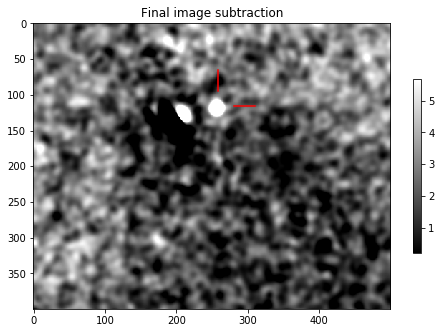

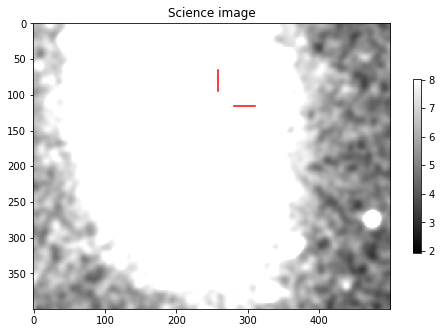

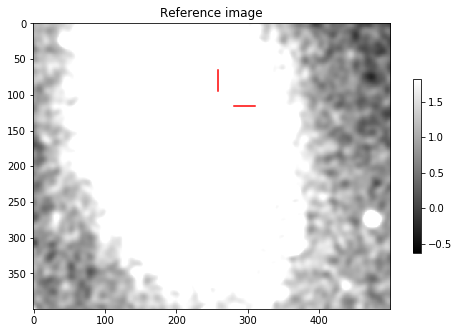

In [21]:
#Plot up the result of the image subtraction
mean, median, std = sigma_clipped_stats(hdu_image_sub.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_image_sub.data[200:600,1100:1600], vmin = median - 2*std, vmax = median + 2*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" )
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
plt.title('Final image subtraction')
plt.show()

#...and plot up the same region of sky of science and template images
mean, median, std = sigma_clipped_stats(sci_conv_shift)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(sci_conv_shift[200:600,1100:1600], vmin = median - 3*std, vmax = median + 3*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" )
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
plt.title('Science image')
plt.show()

mean, median, std = sigma_clipped_stats(ref_conv)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(ref_conv[200:600,1100:1600], vmin = median - 3*std, vmax = median + 3*std, cmap='gray')
plt.plot([280,310],[115,115], "r-" )
plt.plot([258,258],[95,65], "r-" )
plt.colorbar(shrink = 0.4)
plt.title('Reference image')
plt.show()

#ds9 visualization
#os.system('ds9 -zscale '+sci_image_aligned_name +' ' + ref_image_aligned_name + ' sub_final.fits &')

There you go, now you should be able to easily spot the supernova as a white excess on the grey background! <br >

Note that the bright center of the host galaxy was not perfectly subtracted and left a spurious signal that could be mistaken for real luminosity variability.  <br >


These operations can be made automatic and can be incorporated in pipelines that discover transients.  Moreover, using the methods learnt in the Photometry module, you can perform forced PSF photometry on the image subtraction to obtain flux measurement of the transient free from the host galaxy contamination.

# END OF THE SCHOOL MODULE

## Bonus:  HOTPANTS

There are some packages that perform most of the operations above automatically.  One of the most popular is called HOTPANTS, which stands for "High Order Transform of PSF ANd Template Subtraction". <br >

The code can be found on GitHub: https://github.com/acbecker/hotpants <br >  To proceed, install this program and continue.

In [ ]:
#hotpants
os.system("path/to/hotpants -inim"+" "+sci_image_aligned_name+" "+"-tmplim "+ref_image_aligned_name+" -outim out.fits -oci oci.fits -tg 1 -tr 1 -ig 1 -ir 1 -nrx 1 -nry 1 -nsx 2 -nsy 2 -ng 3 6 0.70 4 1.50 2 3.00 -v 0 -bgo 0 -tl 1 -tu 150000 -il 1 -iu 150000 -ko 0")

hotpants_image = fits.open('oci.fits')
image_sub = hotpants_image[0].data-ref_image_aligned[0].data*0.975
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test_hp.fits")
os.system('ds9 -zscale sub_test_hp.fits &')

## Bonus:  Convolving one image only
We can also perform image subtraction after degrading (i.e., convolving with a kernel) only one of the two images. In fact, in some cases it is preferred to keep the science image untouched and manipulate only the reference to avoid introducing errors in photometry measurements.  On the other hand, convolving both images usually leads to "cleaner" image subtraction.

Below are a list of commands to do a better job with manipulating only one image usinf fft techniques. In this example, we manipulate the science image instead of the reference simply because of what the specific characteristics of the images that we are playing with.  Identical methods can be applied to manipulating reference images only. 

In [ ]:
# alternatively to degrade one image only
Im1_psf=np.fft.fftshift(kernel_ref);
Im2_psf=np.fft.fftshift(kernel_sci);

psf_fft1=np.fft.fft2(Im1_psf);
psf_fft2=np.fft.fft2(Im2_psf);


kern=psf_fft1/psf_fft2;
kern_m=np.real(np.fft.fftshift(np.fft.ifft2(kern)))
kern_mean=np.mean(kern_m)
psf_m=(kern_m/(kern_mean*59*59))

plt.imshow(psf_m, cmap='gray')

sci_conv = scipy_convolve(sci_image_aligned[0].data, psf_m, mode='same', method='fft')

from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import numpy.fft

xoff, yoff, exoff, eyoff = chi2_shift(ref_image_aligned[0].data, sci_conv, 10, return_error=True, upsample_factor='auto')
print(xoff,yoff)

sci_conv_shift=scipy.ndimage.shift(sci_conv, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)
                 
os.system("rm sub_test2.fits")
image_sub = sci_conv_shift*scale-ref_image_aligned[0].data
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test2.fits")

os.system('ds9 -zscale sub_test2.fits&')